<h1><b>Black-Litterman Portfolio Optimization Implementation</b></h1>
This notebook demostrates the workflow and steps for portfolio optimization implementation; which includes Data Preperation, Data Processing, Black-Litterman Modeling, Optimization, Portfolio Construction, Back-testing and Performance Presenting.

<b1>Load Libraries</b1>

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import portfolioopt as pfopt

import time
import pandas as pd
import numpy as np
from numpy import split
from numpy import array
from numpy import log
from numpy import zeros
from numpy import concatenate
from scipy import linalg

from matplotlib import pyplot as plt
from datetime import datetime
from math import sqrt

from pandas.tseries.offsets import BMonthEnd, BQuarterEnd, BMonthBegin, BQuarterBegin, BQuarterEnd, BDay
from pandas import read_csv, DataFrame, concat, datetime
from pandas.tseries.offsets import BMonthEnd, BQuarterEnd, MonthBegin, BQuarterBegin, BQuarterEnd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Activation
from keras.utils import np_utils
from attention_decoder import AttentionDecoder
from keras.callbacks import ModelCheckpoint
import keras

import pyfolio as pf
import empyrical as ep

Using TensorFlow backend.


<b>Re-arrange dataset with columns in wanted order</b>

In [2]:
# import os
sCurrentWorkingDirectory = os.getcwd()
print('CurrentWorkingDirectory: ', sCurrentWorkingDirectory, '\n')
sDir = sCurrentWorkingDirectory

# load data
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')

data = read_csv('dataset_update_20181127.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)

ETF_ticker_list = ['SPX', 'NKY', 'SHCOMP', 'SHSZ300', 'GC1_Comdty', 
                   'CL1_Comdty', 'DXY_CURNCY', 'IBOXHY', 'LUTLTRUU', 'LEGATRUU',
                   'LBUSTRUU','SX5E', 'TWSE']
print(len(ETF_ticker_list))
fund_ticker_list = ['MXWD', 'MXEF', 'MXAP', 'MXASJ', 'MXSO', 'SX5E', 'TWSE', 'XIN9I', 'NIFTY',
                    'JCI', 'IBOV', 'NMFIAFG2', 'LBUSTRUU', 'JPEIGLBL', 'SPGNRUN', 'SPAEREDT', 'RUGL']
print(len(fund_ticker_list))

full = ETF_ticker_list + fund_ticker_list

ticker_list = []
for i in full:
    if i not in ticker_list:
        ticker_list.append(i)
        

ETF_tickers = ticker_list[:12]
fund_tickers = ticker_list[9:]
# display(ticker_list, len(ticker_list), ETF_tickers, len(ETF_tickers), fund_tickers, len(fund_tickers))

CurrentWorkingDirectory:  D:\Jupyter\ETFAI\20181217_new_modified 

13
17


In [3]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')

dataset = read_csv('dataset_update_20181127.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
print('Data shape: ',dataset.shape)

index = dataset.index

date_of_rebalance = pd.to_datetime(list(index), format="%Y-%m-%d") + BMonthEnd(1)
date_of_rebalance = date_of_rebalance.drop_duplicates(keep='first')
date_of_rebalance = date_of_rebalance.strftime('%Y-%m-%d')

firstdate_of_month = pd.to_datetime(list(index), format="%Y-%m-%d") + BMonthEnd(1) + BDay(1)
firstdate_of_month = firstdate_of_month.drop_duplicates(keep='first')
firstdate_of_month = firstdate_of_month.strftime('%Y-%m-%d')


enddate_of_month = pd.to_datetime(list(index), format="%Y-%m-%d") + BMonthEnd(1)
enddate_of_month = enddate_of_month.drop_duplicates(keep='first')
enddate_of_month = enddate_of_month.strftime('%Y-%m-%d')
# enddate_of_month = enddate_of_month.insert(-1,index[-1].strftime('%Y-%m-%d'))[:-1]
enddate_of_month = enddate_of_month.insert(-1,'2018-11-27')[:-1]


firstdate_of_quarter = pd.to_datetime(list(index), format="%Y-%m-%d") + BQuarterEnd(1) + BDay(1)
firstdate_of_quarter = firstdate_of_quarter.drop_duplicates(keep='first')

enddate_of_quarter = pd.to_datetime(list(index), format="%Y-%m-%d") + BQuarterEnd(1)
enddate_of_quarter = enddate_of_quarter.drop_duplicates(keep='first')

date_of_rebalance = date_of_rebalance[27:-1]
# date_of_rebalance = date_of_rebalance[27:-3]
print('date_of_rebalance: \n',date_of_rebalance)
print(len(date_of_rebalance), '\n')

firstdate_of_month = firstdate_of_month[27:-1]
# firstdate_of_month = firstdate_of_month[27:-3]
print('firstdate_of_month: \n',firstdate_of_month)
print(len(firstdate_of_month), '\n')

enddate_of_month = enddate_of_month[28:]
# enddate_of_month = enddate_of_month[28:-2]
print('enddate_of_month: \n',enddate_of_month)
print(len(enddate_of_month), '\n')

# ffirstdate_of_quarter = firstdate_of_quarter[9:-2]
# print('Firstdate_of_quarter: \n',ffirstdate_of_quarter)
# print(len(ffirstdate_of_quarter), '\n')

# eenddate_of_quarter = enddate_of_quarter[10:-1]
# print('Enddate_of_quarter: \n',eenddate_of_quarter)
# print(len(eenddate_of_quarter), '\n')

Data shape:  (2664, 73)
date_of_rebalance: 
 Index(['2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31', '2011-04-29',
       '2011-05-31', '2011-06-30', '2011-07-29', '2011-08-31', '2011-09-30',
       '2011-10-31', '2011-11-30', '2011-12-30', '2012-01-31', '2012-02-29',
       '2012-03-30', '2012-04-30', '2012-05-31', '2012-06-29', '2012-07-31',
       '2012-08-31', '2012-09-28', '2012-10-31', '2012-11-30', '2012-12-31',
       '2013-01-31', '2013-02-28', '2013-03-29', '2013-04-30', '2013-05-31',
       '2013-06-28', '2013-07-31', '2013-08-30', '2013-09-30', '2013-10-31',
       '2013-11-29', '2013-12-31', '2014-01-31', '2014-02-28', '2014-03-31',
       '2014-04-30', '2014-05-30', '2014-06-30', '2014-07-31', '2014-08-29',
       '2014-09-30', '2014-10-31', '2014-11-28', '2014-12-31', '2015-01-30',
       '2015-02-27', '2015-03-31', '2015-04-30', '2015-05-29', '2015-06-30',
       '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-30', '2015-11-30',
       '2015-12-31', '2016-01-2

In [4]:
# re-arrange dataset columns order
# create a natural log return series
def ln_return(series):
    #calculate natural log return
    ln_rts = lambda y,x: (y-x)/x
    series = ln_rts(series,series.shift(1))
    return series

ETF_ticker_list = ['SPX', 'NKY', 'SHCOMP', 'SX5E', 'TWSE','GC1_Comdty', 'DXY_CURNCY', 'LUTLTRUU']

# ETF_ticker_list = ['MXWD','GC1_Comdty', 'DXY_CURNCY', 'LUTLTRUU']
# ETF_ticker_list = ['MXWD', 'MXEF', 'MXAP', 'MXASJ', 'MXSO', 'SX5E', 'TWSE', 'XIN9I', 'NIFTY', 
#                    'JCI', 'IBOV', 'NMFIAFG2', 'LBUSTRUU', 'JPEIGLBL', 'SPGNRUN', 'SPAEREDT', 'RUGL']
# ETF_ticker_list = ['MXWD', 'MXEF', 'MXAP', 'MXASJ', 'MXSO', 'SX5E', 'TWSE', 'XIN9I', 'NIFTY', 
#                    'JCI', 'IBOV', 'SPGNRUN', 'SPAEREDT', 'LBUSTRUU']

cols_list = []
for i in range(len(ETF_ticker_list)):
    ticker_list=ETF_ticker_list
    ticker=ticker_list[i]
#     print(i+1,'. ticker: ', ticker)    
    # load data
    def parse(x):
        return datetime.strptime(x, '%Y/%m/%d')

    df = read_csv('dataset_update_20181127.csv',  parse_dates = ['date'], index_col=0, usecols=['date',ticker], date_parser=parse)
    df = ln_return(df)
    cols_list.append(df)

framed_dataset = pd.concat(cols_list,axis=1)
tickers_dataset = framed_dataset
# tickers_dataset = framed_dataset['2011-01-03':'2018-09-27']
print('Data shape: ',tickers_dataset.shape)
print(tickers_dataset.head())
print(tickers_dataset.tail())
# tickers_dataset.to_csv('selected_dataset.csv')

Data shape:  (2664, 8)
                 SPX       NKY    SHCOMP      SX5E      TWSE  GC1_Comdty  \
date                                                                       
2008-09-11       NaN       NaN       NaN       NaN       NaN         NaN   
2008-09-12  0.002135  0.009276  0.000333  0.017355  0.009421    0.025468   
2008-09-15 -0.047129  0.000000  0.000000 -0.038697 -0.040806    0.029961   
2008-09-16  0.017514 -0.049534 -0.044736 -0.019910 -0.047374   -0.008548   
2008-09-17 -0.047111  0.012065 -0.028988 -0.022555  0.007771    0.090078   

            DXY_CURNCY  LUTLTRUU  
date                              
2008-09-11         NaN       NaN  
2008-09-12   -0.014723 -0.012565  
2008-09-15   -0.000722  0.023485  
2008-09-16    0.002015  0.002824  
2008-09-17   -0.012306  0.002912  
                 SPX       NKY    SHCOMP      SX5E      TWSE  GC1_Comdty  \
date                                                                       
2018-11-21  0.003126 -0.003502  0.002136  0.012

In [5]:
# adj_cols_list=[]
# adj_cols_list = cols_list[:-1]
# # print(adj_cols_list)
# adj_cols_list.append(cols_list[-1]+0.0001)
# pd.concat(adj_cols_list,axis=1)

<b>Portfolio Optimization</b>

In [6]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')


cols_list = []
for i in range(len(ETF_ticker_list)):
    ticker_list=ETF_ticker_list
    ticker=ticker_list[i]
#     print(i+1,'. ticker: ', ticker)    
    # load data
    def parse(x):
        return datetime.strptime(x, '%m/%d/%Y')

    df = read_csv('new_aggregated.csv',  parse_dates = ['date'], index_col=0, usecols=['date',ticker], date_parser=parse)
    cols_list.append(df)

aggregated = pd.concat(cols_list,axis=1)
# aggregated = aggregated.iloc[:,:]
print('Data shape: ',aggregated.shape)
print(aggregated.head())
print(aggregated.tail())

Data shape:  (2043, 8)
                 SPX       NKY    SHCOMP      SX5E      TWSE  GC1_Comdty  \
date                                                                       
2010-12-31 -0.008655 -0.018824  0.028230 -0.027206  0.007365    0.014382   
2011-01-03 -0.008655 -0.018824  0.028230 -0.027206  0.007365    0.014382   
2011-01-04 -0.008655 -0.018824  0.028230 -0.027206  0.007365    0.014382   
2011-01-05 -0.011084 -0.018824  0.028230 -0.027206  0.007365    0.014382   
2011-01-06 -0.011084 -0.018824  0.024466 -0.027206  0.007365    0.014382   

            DXY_CURNCY  LUTLTRUU  
date                              
2010-12-31    0.002460  0.018895  
2011-01-03    0.002460  0.018895  
2011-01-04    0.002460  0.018895  
2011-01-05    0.020701  0.018895  
2011-01-06    0.020701  0.018895  
                 SPX       NKY    SHCOMP      SX5E      TWSE  GC1_Comdty  \
date                                                                       
2018-10-25 -0.023251 -0.032423 -0.021777 -0.050

In [7]:
# exrtract views
reb_list =[]
for i in range(len(date_of_rebalance)):
    lmd = date_of_rebalance[i]
#     print(lmd)
    df= aggregated.loc[str(lmd)]
    reb_list.append(df)

lstm_views = pd.concat(reb_list,axis=1)
lstm_views = lstm_views.T
lstm_views = lstm_views.iloc[:,:-3]
print('Data shape: ',lstm_views.shape)
# display(lstm_views.head())
display(lstm_views[:7])
display(lstm_views.tail())
# lstm_views.to_csv('lstm_views.csv')

Data shape:  (95, 5)


,SPX,NKY,SHCOMP,SX5E,TWSE
2010-12-31,-0.008655,-0.018824,0.028230,-0.027206,0.007365
2011-01-31,-0.008655,-0.018824,0.026680,-0.008921,0.007365
2011-02-28,-0.008655,-0.018824,0.026403,-0.008921,0.007365
2011-03-31,-0.014921,-0.010704,0.028230,-0.008921,0.007365
2011-04-29,-0.009471,0.017335,0.007143,0.063040,0.002021
2011-05-31,-0.009471,0.008520,0.007143,0.063040,0.007699
2011-06-30,-0.009471,0.008494,0.007143,0.063040,-0.009079


,SPX,NKY,SHCOMP,SX5E,TWSE
2018-06-29,0.001516,0.008828,0.018780,0.008262,0.036926
2018-07-31,-0.028790,0.017256,-0.057811,-0.111632,0.018177
2018-08-31,-0.028790,0.017256,0.002562,-0.109446,0.009248
2018-09-28,-0.036246,-0.071701,-0.019958,-0.050445,-0.018872
2018-10-31,-0.023251,-0.032423,-0.021777,-0.050445,-0.018872


In [8]:
def create_views_and_link_matrix(names):
    c = len(names)
    P = zeros([c, c])
    for i in range(c):
        P[i][i] = 1
    P = array(P[:-3])
    return P

P = create_views_and_link_matrix(ETF_ticker_list)



print(P.shape)
display(P)

(5, 8)


array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.]])

In [9]:
# import data


# create a natural log return series
# def ln_return(series):
#     #calculate natural log return
#     ln_rts = lambda y,x: y/x-1
#     series = ln_rts(series,series.shift(1))
#     return series

# construct the blacklitterman model
def blacklitterman(returns, tau, P, Q, pt):
    mu = (1+returns.mean())**pt-1 # monthly
    sigma = returns.cov()*pt # monthly
    pi1 = mu
    ts = tau * sigma
    Omega = np.dot(np.dot(P,ts),P.T) * np.eye(Q.shape[0])
    middle = linalg.inv(np.dot(np.dot(P,ts),P.T) + Omega)
    er = np.expand_dims(pi1,axis=0).T + np.dot(np.dot(np.dot(ts,P.T),middle),(Q - np.expand_dims(np.dot(P,pi1.T),axis=1)))
    posteriorSigma = sigma + ts -np.dot(ts.dot(P.T).dot(middle).dot(P),ts)
    return [er, posteriorSigma]

sCurrentWorkingDirectory = os.getcwd()
print('CurrentWorkingDirectory: ', sCurrentWorkingDirectory, '\n')
sDir = sCurrentWorkingDirectory

#
# symbols = ticker_list
# symbols = ETF_tickers
# symbols = fund_tickers[1:]

appended_data = []
col = []


retData = tickers_dataset
print(retData.head())
print(retData.tail())

# # historical mean
# avg_rets = train_set.mean()
# avg_rets = (1+avg_rets)**pt-1 # monthly
# # display(avg_rets)
# # historical covariance matrix
# cov_mat = train_set.cov()*pt # monthly
# # display(cov_mat)

# P = create_views_and_link_matrix(symbols)

frames = []
w = []
MKZ = []
BL = []
truncate = []

# Q_set 
views = lstm_views.values

# investor views (obtained from lstm)

# retData=framed_dataset.iloc[1:,:12]

# set target return
target_ret = 0.005# assuming seeking for a 3% yearly return, which required an 0.74% seasonally return 

pt=20


# retData=framed_dataset.iloc[1:,10:]

for i in range(len(date_of_rebalance)):
    # specify training and testing period
    test_starts_date= date_of_rebalance[i]
    test_starts = retData.index.get_loc(test_starts_date)

    train_starts= test_starts-1-250
    train_ends= test_starts-1

    train_set= retData.iloc[train_starts:train_ends, :]
#     print('test_starts: ',test_starts_date)
#     print(train_set.iloc[:,0].head())
#     print(train_set.iloc[:,0].tail())
#     print('\n')

# for i in range(len(season_train_set)):
    
    # calculate covariance matrix
    cov_mat = train_set.cov()
    cov_mat = cov_mat*pt
    # calculate mean returns
    avg_rets = train_set.mean()
    avg_rets = (1+avg_rets)**pt-1
    # historical mean
#     print(str(i+1) + ' Historical Mean:')
#     print(test_starts_date)
#     display(avg_rets)
#     #historical covariance matrix
#     print(str(j+1) +' Historical Covariance Matrix:')
#     print(date_of_rebalance[j])
#     display(cov_mat)
    

    ##################################################################################################
#     weights = pfopt.markowitz_portfolio(cov_mat, avg_rets, target_ret, allow_short=False)
# #     print(str(i+1) + ' Markowitz portfolio weights:')
# #     print(test_starts_date)
# #     display(weights*100)
    
# #     # save tables
# #     folder_dir = os.path.join(sDir, 'portfolio_log/')
# #     time_saved = time.strftime("_%Y%m%d_%H%M%S")
# #     cov_mat.to_csv(folder_dir + 'Season '+ str(i+1) + '_cov_mat'+ time_saved + '.csv')
#     df_avg_rets = pd.DataFrame(avg_rets, index = avg_rets.index)
#     df_avg_rets.columns = [str(test_starts_date) + ' Historical_Returns']
#     df_weights = pd.DataFrame(weights, index = weights.index)
#     df_weights.columns = [str(test_starts_date) + ' Markowitz_Weights']
#     df_weights.columns = [str(test_starts_date)]

    
    ########################################################################
    
#     df = views[i]
# #     print('\n')
# #     print('LSTM views: ')
# #     display(df)
#     Q = [df]
# #     for j in range(len(df)):
# #     Q.append(df[0])
#     Q = array(Q)
    
    
    df = views[i]
#     print('\n')
#     print('LSTM views: ')
#     display(df)
    Q = []
    for j in range(len(df)):
        Q.append([df[j]])
    Q = array(Q)
    ########################################################################


#     tau = 0.01
    tau = 100

    # adjusted posterior mean returns with black-litterman
    res = blacklitterman(train_set, tau, P, Q, pt)
    p_mean = DataFrame(res[0],index=train_set.columns,columns=[str(i+1) +' posterior_mean'])
#     print(str(j+1) + ' adjusted posterior mean returns with Black-Litterman:')
#     print(test_starts_date)
#     display(p_mean)

    # calculate new weights
    cov_mat2 = res[1]
#     cov_mat2 = cov_mat2
    cov_mat2 = cov_mat2
#     cov_mat2.to_csv(folder_dir + 'Season '+ str(i+1) + '_posterior_cov_mat'+ time_saved + '.csv')
    avg_rets2 = pd.Series(res[0][:,0],index=retData.columns)
#     avg_rets2 = (1+avg_rets2)**pt-1
    weights2 = pfopt.markowitz_portfolio(cov_mat2, avg_rets2, target_ret, allow_short=False)
    weights3 = pfopt.truncate_weights(weights2, min_weight=0.01, rescale=True)
#     print('\n')
#     print(str(i+1) + ' adjusted posterior weights with Black-Litterman:')
#     print(test_starts_date)
#     display(weights2*100)
    
    # Save Table
    df_weights2 = pd.DataFrame(weights2, index = weights2.index)
#     df_weights2.columns = [str(test_starts_date) +' BL_Weights']
    df_weights2.columns = [str(test_starts_date)]
    
    df_weights3 = pd.DataFrame(weights3, index = weights3.index)
#     df_weights2.columns = [str(test_starts_date) +' BL_Weights']
    df_weights3.columns = [str(test_starts_date)]

    
#     print('Season '+ str(i+1) +' daily returns:')
#     # markowitz_portfolio return in test_set
#     test_set = season_test_set[i]
#     test1_return = np.dot(test_set, np.matrix(weights).T)
#     test1_return = pd.DataFrame(test1_return, index = test_set.index)
#     test1_return.columns = ['Markowitz']

#     # BL_portfolio return in test_set
#     test2_return = np.dot(test_set,
#                         np.matrix(weights2).T)
#     test2_return = pd.DataFrame(test2_return, index = test_set.index)
#     test2_return.columns = ['Black-Litterman']
    
    
#     # Combine the portfolios
#     result = pd.concat([test2_return,test1_return], axis=1)
#     frames.append(result)
# #     display(result.head())
# #     display(result.tail())

    # output the weights and returns to csv
#     output = pd.concat([p_mean,df_avg_rets,df_weights2,df_weights], axis=1)
    
#     output = pd.concat([df_weights2,df_weights], axis=1)

#     MKZ.append(df_weights)
    BL.append(df_weights2)
    truncate.append(df_weights3)
    
#     output.to_csv(sDir + 'Season '+ str(i+1) + '_weight_and_returns' + '.csv')

# # combining result
# final_result = pd.concat(frames)

# # adding S&P500 as benchmark to result
# # benchmark_rets = pf.utils.get_symbol_rets('SPY')
# # benchmark_rets = benchmark_rets['2016-01-04':'2016-12-30']
# # benchmark_rets.index = benchmark_rets.index.strftime("%Y-%m-%d")
# # benchmark_rets = pd.DataFrame(benchmark_rets, index = benchmark_rets.index)
# # benchmark_rets.columns = ['S&P 500 Index']
# # final_result = pd.concat([final_result, benchmark_rets], axis=1)
# print('\n','Final result:')
# display(final_result)


BL_weights = pd.concat(BL,axis=1)
BL_weights = BL_weights.T
print('length of BL_weights: ',len(BL_weights), '\n')
display(BL_weights.head())
display(BL_weights[-12:])

truncate_weights = pd.concat(truncate,axis=1)
truncate_weights = truncate_weights.T
print('length of BL_weights: ',len(truncate_weights), '\n')
display(truncate_weights.head())
display(truncate_weights[-12:])

# MKZ_weights = pd.concat(MKZ,axis=1)
# MKZ_weights = MKZ_weights.T
# print('length of MKZ_weights: ',len(MKZ_weights), '\n')
# display(MKZ_weights.head())
# display(MKZ_weights.tail())

CurrentWorkingDirectory:  D:\Jupyter\ETFAI\20181217_new_modified 

                 SPX       NKY    SHCOMP      SX5E      TWSE  GC1_Comdty  \
date                                                                       
2008-09-11       NaN       NaN       NaN       NaN       NaN         NaN   
2008-09-12  0.002135  0.009276  0.000333  0.017355  0.009421    0.025468   
2008-09-15 -0.047129  0.000000  0.000000 -0.038697 -0.040806    0.029961   
2008-09-16  0.017514 -0.049534 -0.044736 -0.019910 -0.047374   -0.008548   
2008-09-17 -0.047111  0.012065 -0.028988 -0.022555  0.007771    0.090078   

            DXY_CURNCY  LUTLTRUU  
date                              
2008-09-11         NaN       NaN  
2008-09-12   -0.014723 -0.012565  
2008-09-15   -0.000722  0.023485  
2008-09-16    0.002015  0.002824  
2008-09-17   -0.012306  0.002912  
                 SPX       NKY    SHCOMP      SX5E      TWSE  GC1_Comdty  \
date                                                                       
201

ValueError: domain error

In [384]:
scaler = 1/(1-BL_weights.iloc[:,-1])

# scaler = (1-BL_weights.iloc[:,-1])/BL_weights.iloc[:,-1]
scaler = scaler.values
prescaled = BL_weights.iloc[:,:-1]
# DataFrame(scaled)*DataFrame(scaled)
# DataFrame(scaled)
i=0
# scaler[i]
# prescaled.iloc[i,:]
prescaled.iloc[i,:]*scaler[i]
df = []
for i in range(len(BL_weights.index)):
    scaler = 1/(1-BL_weights.iloc[:,-1])
    scaler = scaler.values
    prescaled = BL_weights.iloc[:,:-1]
    scaled = prescaled.iloc[i,:]*scaler[i]
    df.append(scaled)
# DataFrame(df).to_csv('model_portfolio.csv')
# DataFrame(df)

,MXWD,MXEF,MXAP,MXASJ,MXSO,SX5E,TWSE,XIN9I,NIFTY,JCI,IBOV,SPGNRUN,SPAEREDT
2010-12-31,0.046008,0.004283,0.156783,0.003672,0.048019,0.004539,0.244764,0.043131,0.286015,0.062095,0.052294,0.009200,0.039198
2011-01-31,0.086710,0.003629,0.003683,0.002875,0.015420,0.006260,0.014585,0.000907,0.026962,0.233066,0.071774,0.008299,0.525831
2011-02-28,0.092164,0.003514,0.004745,0.002323,0.018760,0.004536,0.022928,0.000556,0.396445,0.133195,0.050126,0.009722,0.260987
2011-03-31,0.026822,0.003903,0.003881,0.003048,0.015005,0.005621,0.009753,0.001198,0.431425,0.161694,0.051209,0.009965,0.276476
2011-04-29,0.088819,0.010145,0.047323,0.010985,0.081408,0.014985,0.318472,0.059852,0.155320,0.059274,0.100536,0.013023,0.039859
2011-05-31,0.090281,0.015396,0.038669,0.013438,0.087401,0.019086,0.338669,0.038673,0.105113,0.105064,0.099560,0.012117,0.036534
2011-06-30,0.108455,0.017919,0.037868,0.014658,0.106621,0.023780,0.305848,0.044684,0.097901,0.093019,0.103684,0.010713,0.034850
2011-07-29,0.070986,0.005476,0.370655,0.005774,0.005877,0.004900,0.016691,0.018434,0.261232,0.017787,0.006727,0.014224,0.201237
2011-08-31,0.089362,0.013402,0.260133,0.015957,0.027838,0.009721,0.111968,0.040011,0.277436,0.039445,0.010878,0.020363,0.083485
2011-09-30,0.063945,0.005616,0.121759,0.006564,0.045833,0.005994,0.208148,0.150726,0.283697,0.028035,0.029501,0.009414,0.040767


In [ ]:
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')
model_portfolio = read_csv('model_portfolio.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
print(len(BL_weights))

In [12]:
BL_weights = pd.concat(BL,axis=1)
BL_weights = BL_weights.T
print('length of BL_weights: ',len(BL_weights), '\n')
display(BL_weights.head())
display(BL_weights.tail()*100)
# MKZ_weights = pd.concat(MKZ,axis=1)
# MKZ_weights = MKZ_weights.T
# MKZ_weights.to_csv('MKZ_weights.csv')
# retData.to_csv('ETF_price.csv')

length of BL_weights:  93 



,SPX,NKY,SHCOMP,SX5E,TWSE,GC1_Comdty,DXY_CURNCY,LUTLTRUU
2010-12-31,0.186347,0.035773,0.032582,0.046433,0.114254,0.058512,0.359504,0.166595
2011-01-31,0.195345,0.031043,0.029910,0.044256,0.132739,0.059529,0.347159,0.160019
2011-02-28,0.195712,0.000000,0.035225,0.033245,0.152798,0.084338,0.329545,0.167015
2011-03-31,0.182952,0.000000,0.051571,0.015875,0.167897,0.103391,0.300709,0.177602
2011-04-29,0.181154,0.000000,0.029289,0.102641,0.136003,0.068912,0.313849,0.167869


,SPX,NKY,SHCOMP,SX5E,TWSE,GC1_Comdty,DXY_CURNCY,LUTLTRUU
2018-04-30,15.006705,6.542134,0.000000,3.407029,18.112103,15.059728,33.050933,7.934891
2018-05-31,6.756084,8.745242,2.175263,2.209000,21.655349,15.210141,36.667429,6.581492
2018-06-29,11.708042,4.813675,6.262228,3.455560,11.184538,15.468648,38.498899,8.608409
2018-07-31,0.000000,0.000000,0.000000,0.000000,44.017187,14.520308,5.452502,36.009138
2018-08-31,0.000000,11.342000,0.000000,0.000000,43.231513,0.000000,0.000000,45.426217


In [565]:
# BL_weights.columns = ['SPX', 'NKY', 'SHCOMP', 'SHSZ300', 'SX5E', 'TWSE', 'LEGATRUU']
# BL_weights*100

In [588]:
BL_weights.to_csv('BL_weights.csv')

In [558]:
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')
BL_weights = read_csv('BL_weights.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
print(len(BL_weights))

94


In [424]:
# len(BL_weights.index)
# firstdate_of_month[0]
# enddate_of_month[0].strftime('%Y-%m-%d')
retData.iloc[:,0].tail()

date
2018-11-21    0.003126
2018-11-22    0.000000
2018-11-23   -0.006503
2018-11-26    0.015652
2018-11-27    0.000000
Freq: B, Name: SPX, dtype: float64

In [634]:
scaler = 1/(1-truncate_weights.iloc[:,-1])

# scaler = (1-BL_weights.iloc[:,-1])/BL_weights.iloc[:,-1]
scaler = scaler.values
prescaled = truncate_weights.iloc[:,:-1]
# DataFrame(scaled)*DataFrame(scaled)
# DataFrame(scaled)
i=0
# scaler[i]
# prescaled.iloc[i,:]
prescaled.iloc[i,:]*scaler[i]
df = []
for i in range(len(truncate_weights.index)):
    scaler = 1/(1-truncate_weights.iloc[:,-1])
    scaler = scaler.values
    prescaled = truncate_weights.iloc[:,:-1]
    scaled = prescaled.iloc[i,:]*scaler[i]
    df.append(scaled)
# DataFrame(df).to_csv('hedge_model_portfolio.csv')
# DataFrame(df)

,SPX,NKY,SHCOMP,SX5E,TWSE,GC1_Comdty,DXY_CURNCY
2010-12-31,0.223598,0.042924,0.039095,0.055714,0.137094,0.070209,0.431367
2011-01-31,0.232559,0.036957,0.035608,0.052686,0.158027,0.070869,0.413294
2011-02-28,0.235553,0.000000,0.042395,0.040012,0.183903,0.101507,0.396630
2011-03-31,0.222462,0.000000,0.062708,0.019304,0.204157,0.125720,0.365650
2011-04-29,0.217773,0.000000,0.035210,0.123389,0.163495,0.082842,0.377291
2011-05-31,0.249621,0.000000,0.025359,0.092190,0.171017,0.072062,0.389751
2011-06-30,0.257552,0.000000,0.046110,0.133465,0.127767,0.091319,0.343788
2011-07-29,0.183165,0.029634,0.000000,0.000000,0.000000,0.212736,0.574466
2011-08-31,0.199411,0.051809,0.000000,0.000000,0.000000,0.218148,0.530633
2011-09-30,0.221822,0.081167,0.000000,0.016057,0.000000,0.124033,0.556922


In [10]:
# truncate_weights
truncate_weights.columns = ['SPX', 'NKY', 'SHCOMP', 'SX5E', 'TWSE','GC1_Comdty', 'DXY_CURNCY', 'LEGATRUU']
display(truncate_weights.head())
display(truncate_weights.tail()*100)
# truncate_weights.to_csv('truncate_weights.csv')
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')
# BL_weights = read_csv('truncate_weights.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
print(len(BL_weights))
display(BL_weights.head())
display(BL_weights.tail()*100)

NameError: name 'truncate_weights' is not defined

In [11]:
BL_weights.columns = ['SPX', 'NKY', 'SHCOMP', 'SX5E', 'TWSE','GC1_Comdty', 'DXY_CURNCY', 'LEGATRUU']
display(BL_weights.head())
display(BL_weights.tail()*100)


NameError: name 'BL_weights' is not defined

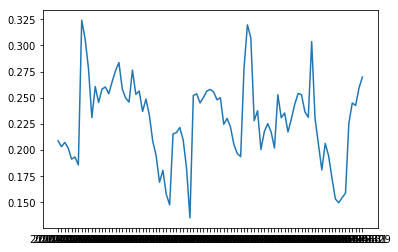

In [667]:
hedge_weights= truncate_weights['GC1_Comdty']+truncate_weights['DXY_CURNCY']
hedge_weights= hedge_weights*0.5
plt.plot(hedge_weights.iloc[:-2])
hedge_weights.to_csv('hedge_weights.csv')

In [670]:
# ETF_ticker_list = ['SPX', 'NKY', 'SHCOMP', 'SHSZ300', 'SX5E', 'TWSE', 'LEGATRUU']
ETF_ticker_list = ['SPX', 'NKY', 'SHCOMP', 'SX5E', 'TWSE','LEGATRUU','GC1_Comdty', 'DXY_CURNCY']
# BL_weights.columns = ['SPX', 'NKY', 'SHCOMP', 'SX5E', 'TWSE','GC1_Comdty', 'DXY_CURNCY', 'LEGATRUU']

# retData = tickers_dataset

cols_list = []
for i in range(len(ETF_ticker_list)):
    ticker_list=ETF_ticker_list
    ticker=ticker_list[i]
#     print(i+1,'. ticker: ', ticker)    
    # load data
    def parse(x):
        return datetime.strptime(x, '%Y/%m/%d')

    df = read_csv('dataset_update_20181127.csv',  parse_dates = ['date'], index_col=0, usecols=['date',ticker], date_parser=parse)
    df=ln_return(df)
    cols_list.append(df)

framed_dataset = pd.concat(cols_list,axis=1)
priceData = framed_dataset
# tickers_dataset = framed_dataset['2011-01-03':'2018-09-27']
print('Data shape: ',priceData.shape)
# print(priceData.head())
# print(priceData.tail())
# tickers_dataset.to_csv('price_dataset.csv')


Data shape:  (2664, 8)


In [443]:
# retData

In [435]:
# print('BL_weights: ',len(BL_weights.index))
# print(BL_weights.index)

# print('firstdate_of_month: ',len(firstdate_of_month))
# print(firstdate_of_month)

# print('enddate_of_month: ',len(enddate_of_month))
# print(enddate_of_month)
BL_weights.iloc[6]*initial

Balance   NaN
Name: 2011-01-10 00:00:00, dtype: float64

number_of_rebalance:  95
number_of_rebalance:  95
Portfolio balance calculating
 Done!


Start date,2010-12-31
End date,2018-11-23
Total months,98
,Backtest
Annual return,4.5%
Cumulative returns,43.4%
Annual volatility,4.3%
Sharpe ratio,1.04
Calmar ratio,0.36
Stability,0.96
Max drawdown,-12.5%


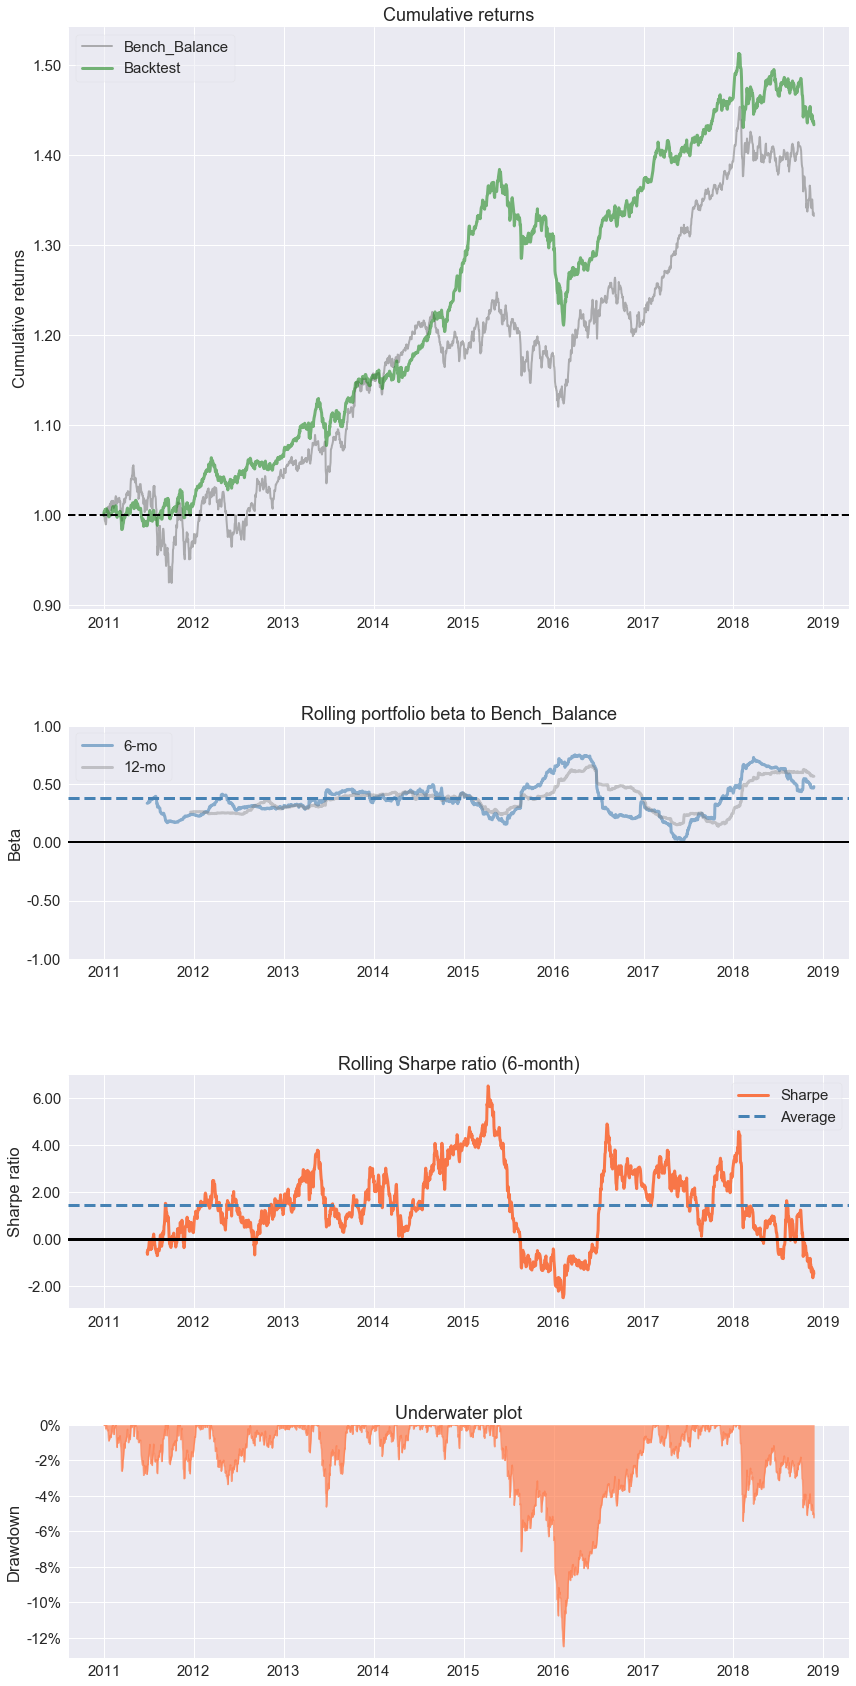

In [631]:
# BL_weights = DataFrame(df)
# BL_weights = read_csv('BL_weights.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
# BL_weights =truncate_weights
number_of_rebalance = len(BL_weights.index)
print('number_of_rebalance: ',number_of_rebalance)
retData = tickers_dataset
initial = 10000

df_balance = []
df_date = []

retData = framed_dataset

# BL_weights = read_csv('BL_weights.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
number_of_rebalance = len(BL_weights.index)
print('number_of_rebalance: ',number_of_rebalance)

for i in range(number_of_rebalance):
    # specify training and testing period
    starts_date= firstdate_of_month[i]
    test_starts = retData.index.get_loc(starts_date)
    ends_date= enddate_of_month[i]
    test_ends = retData.index.get_loc(ends_date)
    cal_set= retData.iloc[test_starts:test_ends, :]
#     print(cal_set)
#     print(i+1)
#     print('test_starts: ',starts_date , test_starts)
#     print(cal_set.iloc[:,:2].head())
#     print(cal_set.iloc[:,:2].tail())
#     print('test_ends: ',ends_date, test_ends, '\n')

    df_date.append(BL_weights.index[i])
    db = BL_weights.iloc[i]*initial
#         initial = db.sum()*(1-0.0015)
    initial = db.sum()
#     print('initial balance: ',db.sum(),'\n')
    df_balance.append(initial)
#     print('Balance after re-balance: ',initial, '\n')
    balance = db
#     print(db)

    for j in range(len(cal_set.index)):
#         print(cal_set.index[j])
        df_date.append(cal_set.index[j].strftime('%Y-%m-%d'))
        rrr = cal_set+1
        rr = rrr.iloc[j]
#         print('rr:\n',rr, '\n')
        balance = rr*balance
#         print(balance)
        initial = balance.sum()
        df_balance.append(initial)
#         print('Daily balance:\n',initial, '\n')

portfolio_balance = pd.DataFrame(df_balance,index = df_date, columns = ['Balance'])
portfolio_balance.index = pd.to_datetime(portfolio_balance.index)
#     portfolio_balance.to_csv(filename+'_portfolio_balance1.csv')
portfolio_balance.to_csv('hedge_portfolio_balance1.csv')
print('Portfolio balance calculating\n','Done!')



# # benchmark
# def parse(x):
#     return datetime.strptime(x, '%Y/%m/%d')
# benchmark0 = read_csv('dataset_update_20181127.csv',  parse_dates = ['date'], index_col=0, usecols=['date','MXWD'], date_parser=parse)
# benchmark0 = ln_return(benchmark0)
# benchmark1 = DataFrame(retData['LEGATRUU'])
# # benchmark1 = read_csv('dataset_update_20181127.csv',  parse_dates = ['date'], index_col=0, usecols=['date','LEGATRUU'], date_parser=parse)
# # benchmark1 = ln_return(benchmark1)
# benchmark1.index = pd.to_datetime(benchmark1.index)
# # display(benchmark0.tail())
# # display(benchmark1.tail())
# benchmark = pd.concat([benchmark0,benchmark1],axis=1)
# benchmark = benchmark.iloc[:-1,:]
# print(benchmark.tail())

# i=0
# filename = file_list[i]
# def parse(x):
#     return datetime.strptime(x, '%Y/%m/%d')
# bench_weights = read_csv('bench_weights'+ filename +'.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
# bench_weights.columns = ['MXWD','LEGATRUU']
# print(bench_weights.tail())


# # backtesting benchmarke performance
# # benchmark initial balance
# initial = 10000

# df_date = []
# df_balance = []

# number_of_rebalance = len(bench_weights.index)
# print(number_of_rebalance)


# for i in range(number_of_rebalance):
#     # specify training and testing period
#     starts_date= firstdate_of_month[i]
#     test_starts = benchmark.index.get_loc(starts_date)
#     ends_date= enddate_of_month[i]
#     test_ends = benchmark.index.get_loc(ends_date)
#     cal_set= benchmark.iloc[test_starts:test_ends, :]


#     df_date.append(bench_weights.index[i])
#     db = bench_weights.iloc[i]*initial
#     initial = db.sum()*(1-0.0015)
#     initial = db.sum()
#     df_balance.append(initial)
#     balance = db

#     for j in range(len(cal_set.index)):
#         df_date.append(cal_set.index[j].strftime('%Y-%m-%d'))
#         rrr = cal_set+1
#         rr = rrr.iloc[j]
#         balance = rr*balance
#         initial = balance.sum()
#         df_balance.append(initial)

# bench_balance = pd.DataFrame(df_balance,index = df_date, columns = ['Bench_Balance'])
# bench_balance.index = pd.to_datetime(bench_balance.index)
# # bench_balance.to_csv(filename+'_bench_balance.csv')
# print('Benchmark balance calculating\n','Done!')


df = ln_return(portfolio_balance)
df = df.iloc[:,0]
df2 = ln_return(bench_balance)
df2 = df2.iloc[:,0]

new_perf_list = perf_list

info_ratio = pd.Series(ep.excess_sharpe(df,df2),index=['Information ratio'])
stats_sheet = DataFrame(pf.timeseries.perf_stats(df,df2).append(info_ratio))
new_perf_list.append(stats_sheet)
pf.create_simple_tear_sheet(df,benchmark_rets=df2)

In [621]:
stats_sheet=concat(new_perf_list,axis=1)
stats_sheet.columns = ['82','73','64','55','46','hedge']
display(stats_sheet)

,82,73,64,55,46,hedge
Annual return,0.065547,0.058132,0.050745,0.043366,0.035969,0.050678
Cumulative returns,0.680750,0.587450,0.499051,0.415091,0.335106,0.486271
Annual volatility,0.086381,0.075645,0.065613,0.056485,0.048651,0.043715
Sharpe ratio,0.778730,0.785322,0.787715,0.780255,0.751086,1.153400
Calmar ratio,0.372078,0.374627,0.381614,0.394461,0.386159,0.405430
Stability,0.942378,0.944540,0.946579,0.948098,0.947921,0.956820
Max drawdown,-0.176164,-0.155172,-0.132974,-0.109936,-0.093147,-0.124998
Omega ratio,1.153763,1.154262,1.153475,1.150223,1.142578,1.226070
Sortino ratio,1.055559,1.066238,1.073730,1.071360,1.041746,1.608096
Skew,NaN,NaN,NaN,NaN,NaN,NaN


82  portfolio performance:
number_of_rebalance:  95
Portfolio balance calculating
 Done!
                MXWD  LEGATRUU
date                          
2018-11-20 -0.016182 -0.001813
2018-11-21  0.003857 -0.001009
2018-11-22 -0.000109  0.000894
2018-11-23 -0.004750 -0.000665
2018-11-26  0.011761 -0.001280
            MXWD  LEGATRUU
date                      
2018-06-29   0.8       0.2
2018-07-31   0.8       0.2
2018-08-31   0.8       0.2
2018-09-28   0.8       0.2
2018-10-31   0.8       0.2
95
Benchmark balance calculating
 Done!


Start date,2010-12-31
End date,2018-11-23
Total months,98
,Backtest
Annual return,5.4%
Cumulative returns,54.2%
Annual volatility,6.6%
Sharpe ratio,0.84
Calmar ratio,0.33
Stability,0.95
Max drawdown,-16.7%


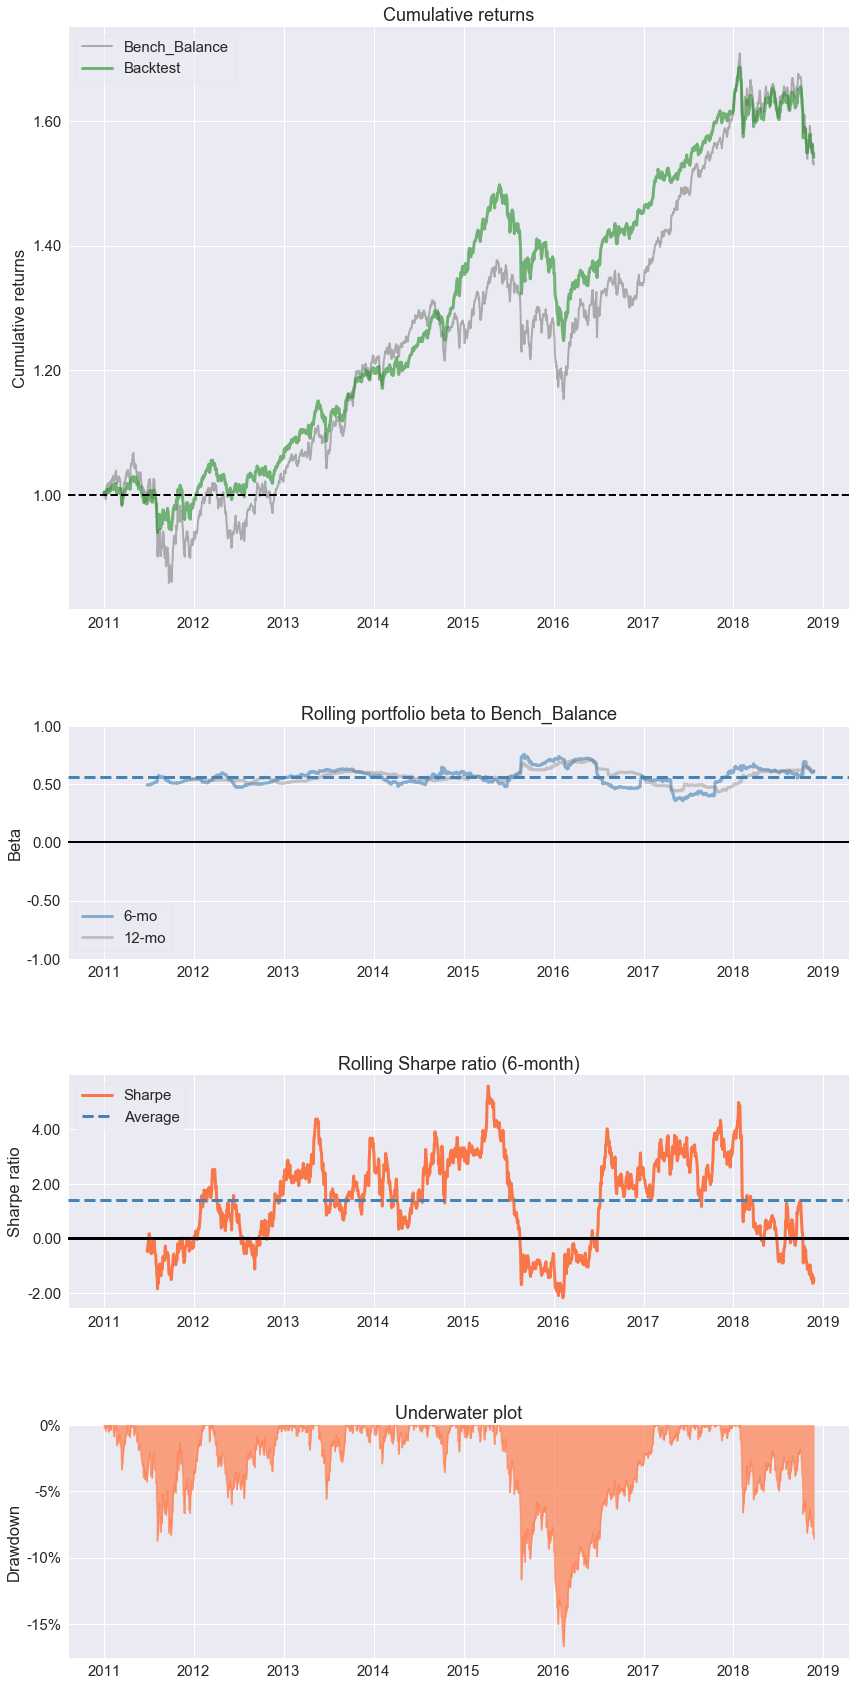

73  portfolio performance:
number_of_rebalance:  95
Portfolio balance calculating
 Done!
                MXWD  LEGATRUU
date                          
2018-11-20 -0.016182 -0.001813
2018-11-21  0.003857 -0.001009
2018-11-22 -0.000109  0.000894
2018-11-23 -0.004750 -0.000665
2018-11-26  0.011761 -0.001280
            MXWD  LEGATRUU
date                      
2018-06-29   0.7       0.3
2018-07-31   0.7       0.3
2018-08-31   0.7       0.3
2018-09-28   0.7       0.3
2018-10-31   0.7       0.3
95
Benchmark balance calculating
 Done!


Start date,2010-12-31
End date,2018-11-23
Total months,98
,Backtest
Annual return,4.9%
Cumulative returns,47.8%
Annual volatility,5.8%
Sharpe ratio,0.86
Calmar ratio,0.33
Stability,0.95
Max drawdown,-14.8%


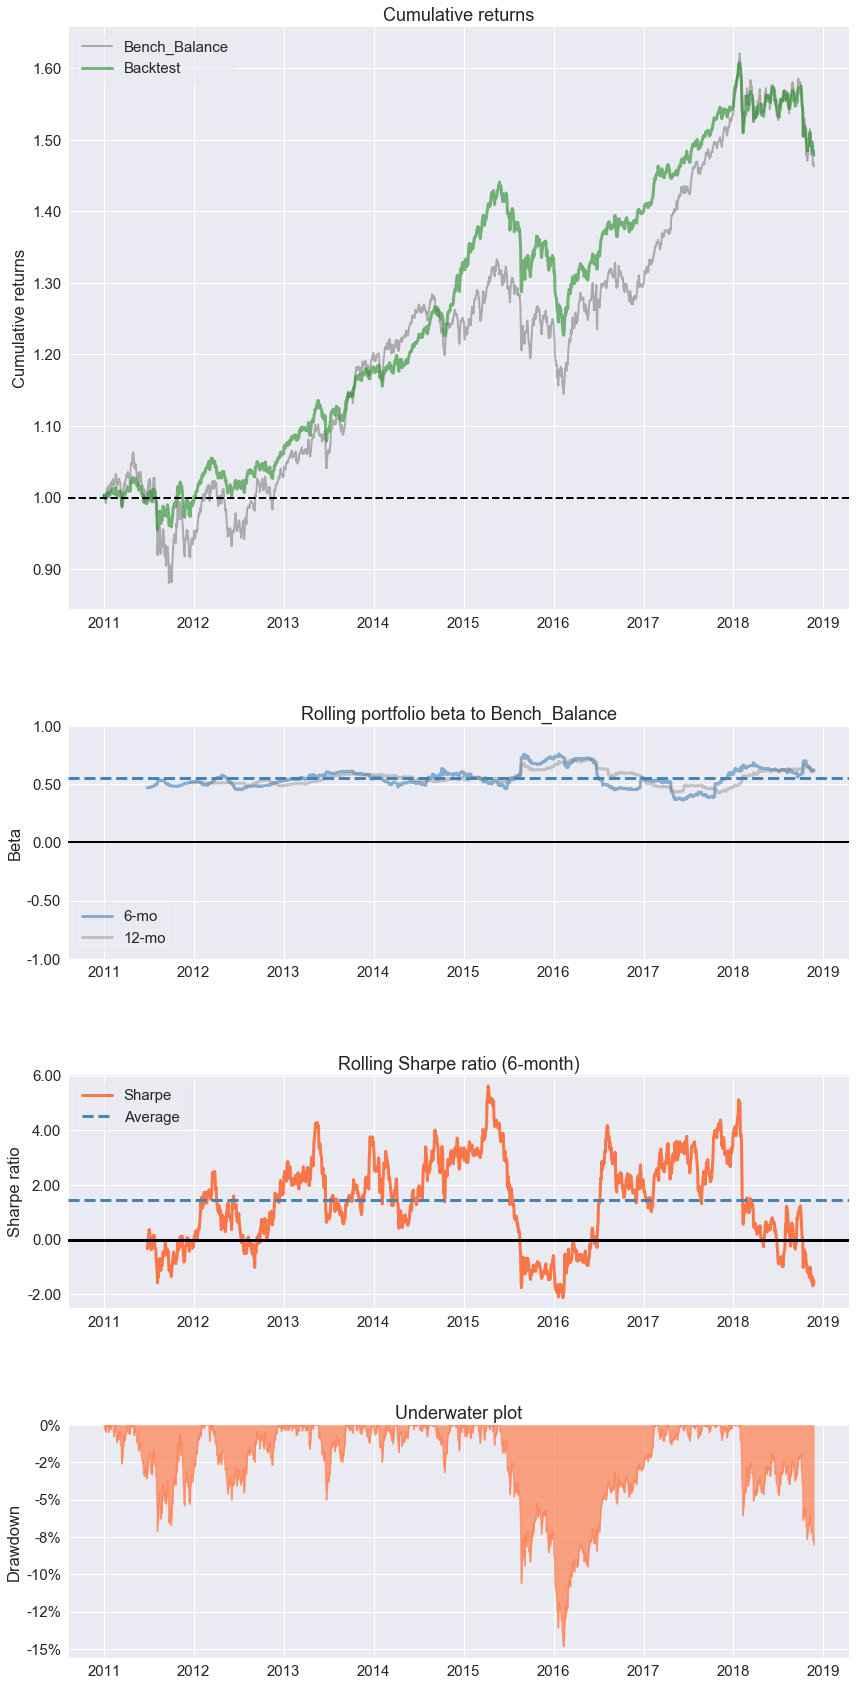

64  portfolio performance:
number_of_rebalance:  95
Portfolio balance calculating
 Done!
                MXWD  LEGATRUU
date                          
2018-11-20 -0.016182 -0.001813
2018-11-21  0.003857 -0.001009
2018-11-22 -0.000109  0.000894
2018-11-23 -0.004750 -0.000665
2018-11-26  0.011761 -0.001280
            MXWD  LEGATRUU
date                      
2018-06-29   0.6       0.4
2018-07-31   0.6       0.4
2018-08-31   0.6       0.4
2018-09-28   0.6       0.4
2018-10-31   0.6       0.4
95
Benchmark balance calculating
 Done!


Start date,2010-12-31
End date,2018-11-23
Total months,98
,Backtest
Annual return,4.4%
Cumulative returns,41.8%
Annual volatility,5.0%
Sharpe ratio,0.89
Calmar ratio,0.34
Stability,0.95
Max drawdown,-12.9%


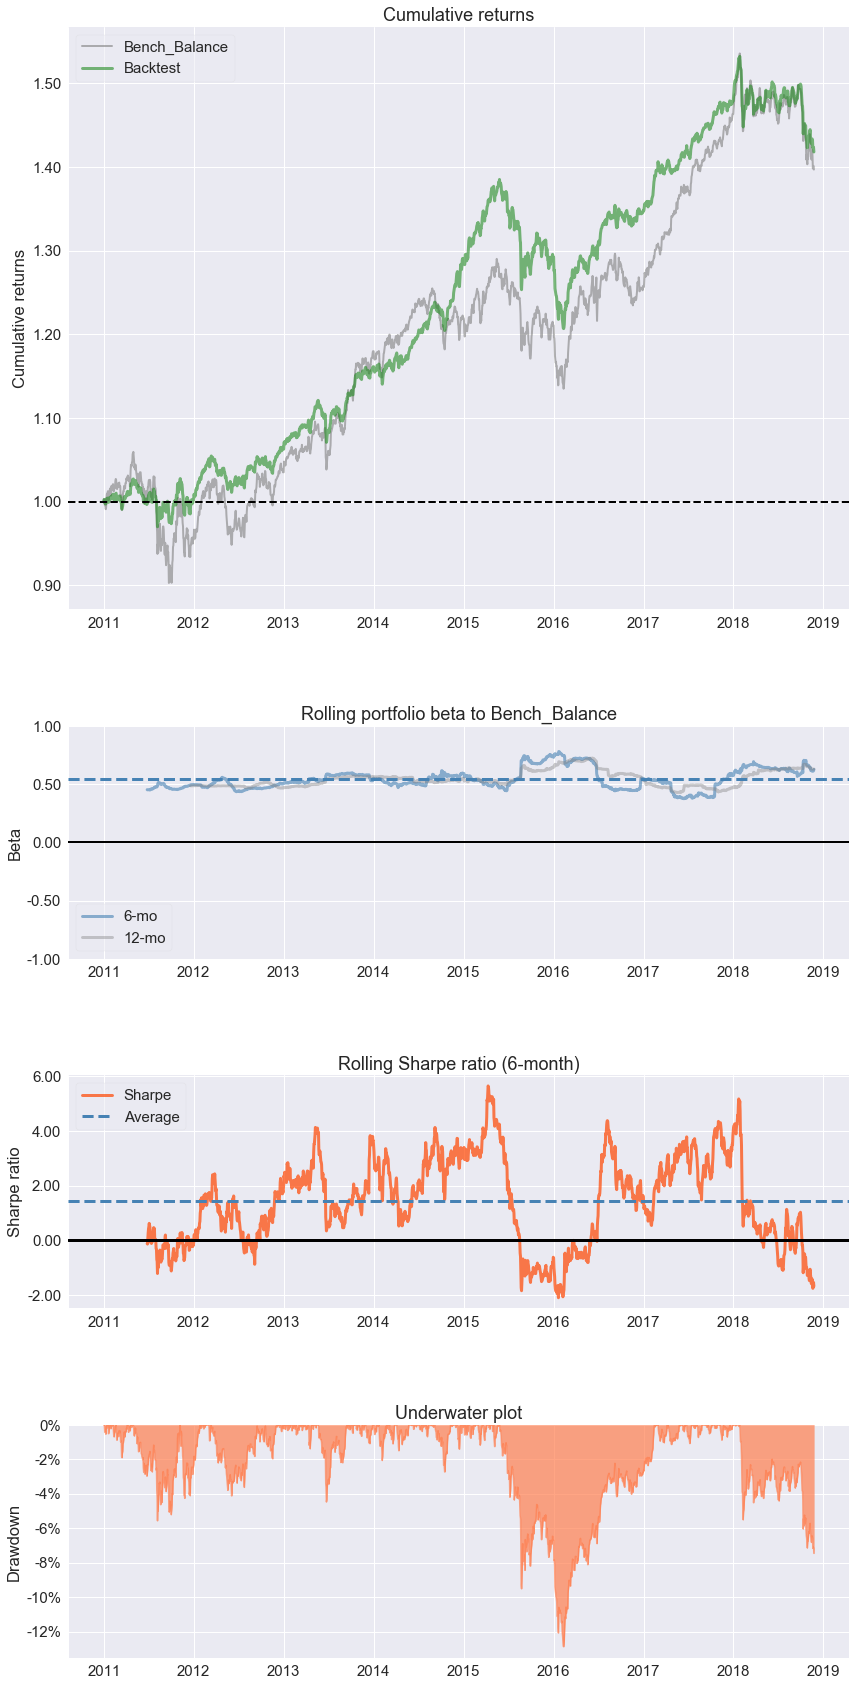

55  portfolio performance:
number_of_rebalance:  95
Portfolio balance calculating
 Done!
                MXWD  LEGATRUU
date                          
2018-11-20 -0.016182 -0.001813
2018-11-21  0.003857 -0.001009
2018-11-22 -0.000109  0.000894
2018-11-23 -0.004750 -0.000665
2018-11-26  0.011761 -0.001280
            MXWD  LEGATRUU
date                      
2018-06-29   0.5       0.5
2018-07-31   0.5       0.5
2018-08-31   0.5       0.5
2018-09-28   0.5       0.5
2018-10-31   0.5       0.5
95
Benchmark balance calculating
 Done!


Start date,2010-12-31
End date,2018-11-23
Total months,98
,Backtest
Annual return,3.8%
Cumulative returns,36.0%
Annual volatility,4.2%
Sharpe ratio,0.91
Calmar ratio,0.35
Stability,0.95
Max drawdown,-10.8%


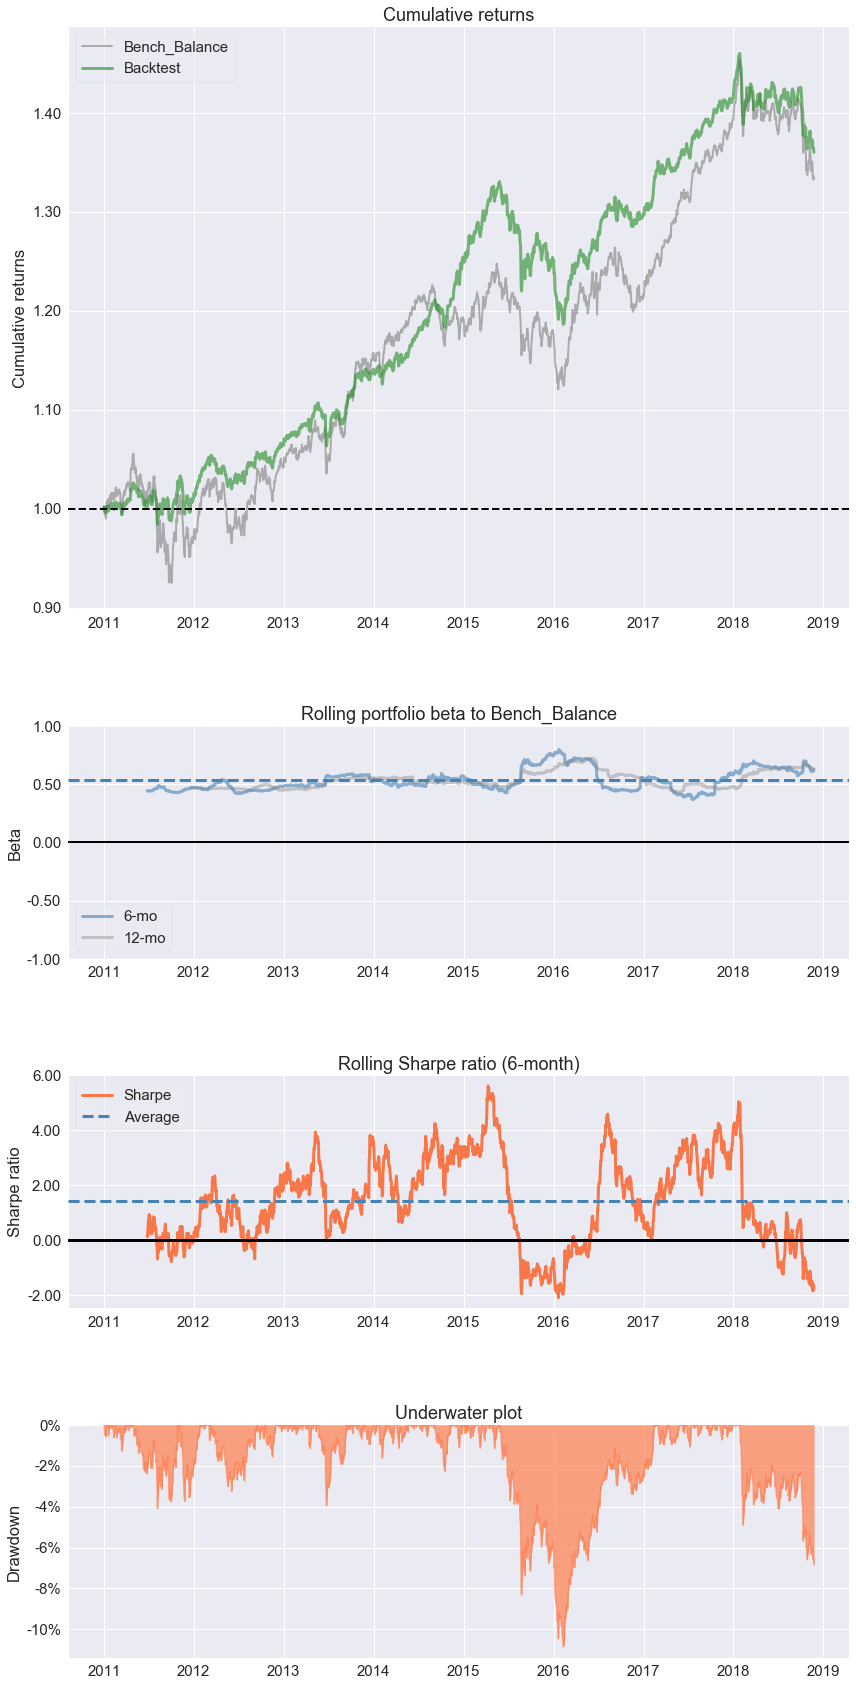

46  portfolio performance:
number_of_rebalance:  95
Portfolio balance calculating
 Done!
                MXWD  LEGATRUU
date                          
2018-11-20 -0.016182 -0.001813
2018-11-21  0.003857 -0.001009
2018-11-22 -0.000109  0.000894
2018-11-23 -0.004750 -0.000665
2018-11-26  0.011761 -0.001280
            MXWD  LEGATRUU
date                      
2018-06-29   0.4       0.6
2018-07-31   0.4       0.6
2018-08-31   0.4       0.6
2018-09-28   0.4       0.6
2018-10-31   0.4       0.6
95
Benchmark balance calculating
 Done!


Start date,2010-12-31
End date,2018-11-23
Total months,98
,Backtest
Annual return,3.3%
Cumulative returns,30.4%
Annual volatility,3.6%
Sharpe ratio,0.92
Calmar ratio,0.38
Stability,0.96
Max drawdown,-8.8%


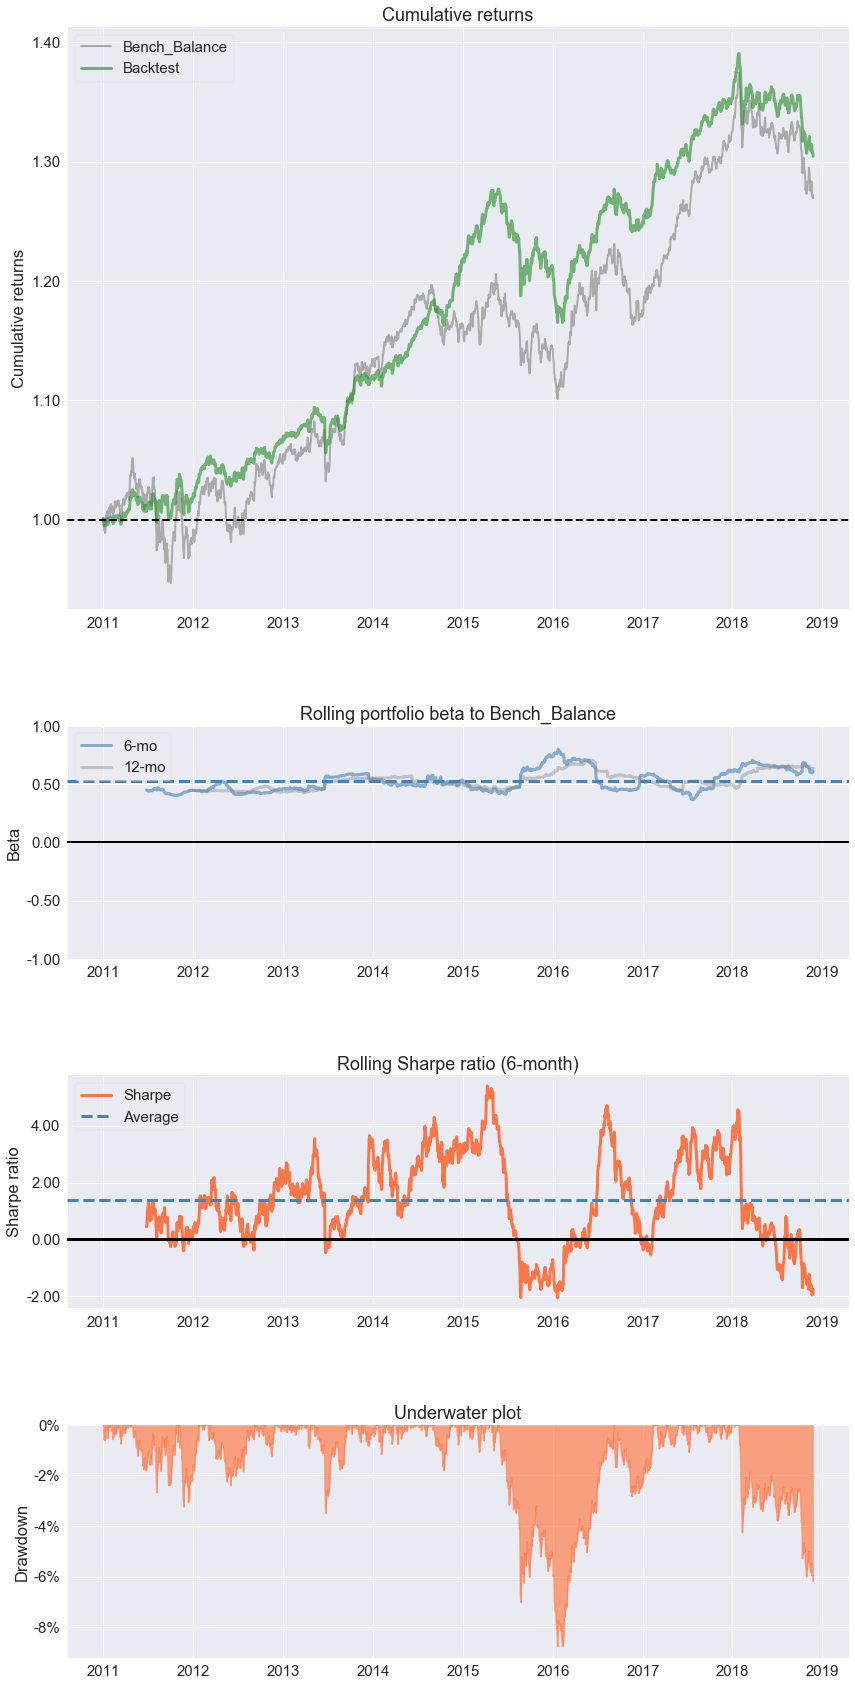

In [684]:
# i= 4
file_list = ['82','73','64','55','46']
h_file_list = ['82_h','73_h','64_h','55_h','46_h']
perf_list = []

retData = framed_dataset

for i in range(len(file_list)):
    print(file_list[i], ' portfolio performance:')
    h_filename = h_file_list[i]
    filename = file_list[i]
    # backtesting lstm protfolio
    def parse(x):
        return datetime.strptime(x, '%Y/%m/%d')
    BL_weights = read_csv(h_filename+'.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)

    # print(len(BL_weights))
    # print(BL_weights)
    # portfolio initial balance
    initial = 10000

    df_balance = []
    df_date = []

    retData = framed_dataset

    # BL_weights = read_csv('BL_weights.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
    number_of_rebalance = len(BL_weights.index)
    print('number_of_rebalance: ',number_of_rebalance)

    for i in range(number_of_rebalance):
        # specify training and testing period
        starts_date= firstdate_of_month[i]
        test_starts = retData.index.get_loc(starts_date)
        ends_date= enddate_of_month[i]
        test_ends = retData.index.get_loc(ends_date)
        cal_set= retData.iloc[test_starts:test_ends, :]
    #     print(cal_set)
    #     print(i+1)
    #     print('test_starts: ',starts_date , test_starts)
    #     print(cal_set.iloc[:,:2].head())
    #     print(cal_set.iloc[:,:2].tail())
    #     print('test_ends: ',ends_date, test_ends, '\n')

        df_date.append(BL_weights.index[i])
        db = BL_weights.iloc[i]*initial
#         initial = db.sum()*(1-0.0015)
        initial = db.sum()
    #     print('initial balance: ',db.sum(),'\n')
        df_balance.append(initial)
    #     print('Balance after re-balance: ',initial, '\n')
#         balance = db
        balance = initial*BL_weights.iloc[i]

#         print(balance)

        for j in range(len(cal_set.index)):
    #         print(cal_set.index[j])
            df_date.append(cal_set.index[j].strftime('%Y-%m-%d'))
            rrr = cal_set+1
            rr = rrr.iloc[j]
    #         print('rr:\n',rr, '\n')
            balance = rr*balance
    #         print(balance)
            initial = balance.sum()
            df_balance.append(initial)
#             print('Daily balance:\n',initial, '\n')

    portfolio_balance = pd.DataFrame(df_balance,index = df_date, columns = ['Balance'])
    portfolio_balance.index = pd.to_datetime(portfolio_balance.index)
#     portfolio_balance.to_csv(filename+'_portfolio_balance.csv')
    print('Portfolio balance calculating\n','Done!')



    # benchmark
    
    def parse(x):
        return datetime.strptime(x, '%Y/%m/%d')
    benchmark0 = read_csv('dataset_update_20181127.csv',  parse_dates = ['date'], index_col=0, usecols=['date','MXWD'], date_parser=parse)
    benchmark0 = ln_return(benchmark0)
    benchmark1 = DataFrame(retData['LEGATRUU'])
    # benchmark1 = read_csv('dataset_update_20181127.csv',  parse_dates = ['date'], index_col=0, usecols=['date','LEGATRUU'], date_parser=parse)
    # benchmark1 = ln_return(benchmark1)
    benchmark1.index = pd.to_datetime(benchmark1.index)
    # display(benchmark0.tail())
    # display(benchmark1.tail())
    benchmark = pd.concat([benchmark0,benchmark1],axis=1)
    benchmark = benchmark.iloc[:-1,:]
    print(benchmark.tail())

    def parse(x):
        return datetime.strptime(x, '%Y/%m/%d')
    bench_weights = read_csv('bench_weights'+ filename +'.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
    bench_weights.columns = ['MXWD','LEGATRUU']
    print(bench_weights.tail())


    # backtesting benchmarke performance
    # benchmark initial balance
    initial = 10000

    df_date = []
    df_balance = []

    number_of_rebalance = len(bench_weights.index)
    print(number_of_rebalance)


    for i in range(number_of_rebalance):
        # specify training and testing period
        starts_date= firstdate_of_month[i]
        test_starts = benchmark.index.get_loc(starts_date)
        ends_date= enddate_of_month[i]
        test_ends = benchmark.index.get_loc(ends_date)
        cal_set= benchmark.iloc[test_starts:test_ends, :]


        df_date.append(bench_weights.index[i])
#         db = bench_weights.iloc[i]*initial*(1-0.0015)
        db = bench_weights.iloc[i]*initial

#         initial = db.sum()*(1-0.0015)
        initial = db.sum()
        df_balance.append(initial)
        balance = initial*bench_weights.iloc[i]

        for j in range(len(cal_set.index)):
            df_date.append(cal_set.index[j].strftime('%Y-%m-%d'))
            rrr = cal_set+1
            rr = rrr.iloc[j]
            balance = rr*balance
            initial = balance.sum()
            df_balance.append(initial)

    bench_balance = pd.DataFrame(df_balance,index = df_date, columns = ['Bench_Balance'])
    bench_balance.index = pd.to_datetime(bench_balance.index)
#     bench_balance.to_csv(filename+'_bench_balance.csv')
    print('Benchmark balance calculating\n','Done!')


    # # print portfolio report
    df = ln_return(portfolio_balance)
    df = df.iloc[:,0]
    df2 = ln_return(bench_balance)
    df2 = df2.iloc[:,0]
    # periods = ['2010-12-31','2015-11-26','2017-11-26','2018-05-24','2018-08-26','2018-10-25','2018-11-25']
    # # periods = pd.to_datetime(periods).tz_localize('UTC')
    # periods = pd.to_datetime(periods)
    # j=1
    
    info_ratio = pd.Series(ep.excess_sharpe(df,df2),index=['Information ratio'])
    stats_sheet = DataFrame(pf.timeseries.perf_stats(df,df2).append(info_ratio))
    perf_list.append(stats_sheet)
    pf.create_simple_tear_sheet(df,benchmark_rets=df2)

In [683]:
stats_sheet=concat(perf_list,axis=1)
stats_sheet.columns = file_list
display(stats_sheet)

,82,73,64,55,46
Annual return,0.036324,0.031025,0.025774,0.020559,0.015362
Cumulative returns,0.338853,0.283873,0.231369,0.181092,0.132789
Annual volatility,0.066161,0.057799,0.049946,0.042748,0.036495
Sharpe ratio,0.572716,0.557823,0.534767,0.497699,0.436196
Calmar ratio,0.203646,0.194018,0.183572,0.170672,0.153375
Stability,0.907789,0.906294,0.903290,0.897068,0.882757
Max drawdown,-0.178370,-0.159907,-0.140404,-0.120460,-0.100158
Omega ratio,1.107648,1.104105,1.098850,1.090835,1.078372
Sortino ratio,0.786571,0.765966,0.734856,0.685188,0.601980
Skew,NaN,NaN,NaN,NaN,NaN


In [676]:
stats_sheet=concat(perf_list,axis=1)
stats_sheet.columns = file_list
display(stats_sheet)

,82,73,64,55,46
Annual return,0.054553,0.049160,0.043817,0.038510,0.033222
Cumulative returns,0.544068,0.480661,0.420108,0.362126,0.306419
Annual volatility,0.066426,0.058088,0.050262,0.043095,0.036874
Sharpe ratio,0.833357,0.855702,0.878846,0.898891,0.905247
Calmar ratio,0.326284,0.331089,0.340428,0.354944,0.379089
Stability,0.945234,0.948251,0.951458,0.954690,0.957391
Max drawdown,-0.167195,-0.148480,-0.128712,-0.108497,-0.087635
Omega ratio,1.159511,1.163025,1.166368,1.168809,1.168204
Sortino ratio,1.157949,1.190717,1.226264,1.259485,1.274966
Skew,NaN,NaN,NaN,NaN,NaN


In [241]:
periods = ['2010-12-31','2015-11-26','2017-11-26','2018-05-24','2018-08-26','2018-10-25','2018-11-25']
pd.to_datetime(periods).tz_localize('UTC')[0]

Timestamp('2010-12-31 00:00:00+0000', tz='UTC')

In [216]:
# i=0
# file_list = ['82','73','64','55','46']
# filename = file_list[i]
# backtesting lstm protfolio
# def parse(x):
#     return datetime.strptime(x, '%Y/%m/%d')
# MKZ_weights = read_csv(filename+'.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
# BL_weights = read_csv(filename+'.xlsx',  parse_dates = ['date'], index_col=0, date_parser=parse)

print(len(MKZ_weights))
print(MKZ_weights)
# portfolio initial balance
initial = 10000

df_balance = []
df_date = []
# BL_weights = read_csv('BL_weights.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
number_of_rebalance = len(MKZ_weights.index)
print('number_of_rebalance: ',number_of_rebalance)

retData=

for i in range(number_of_rebalance):
    # specify training and testing period
    starts_date= firstdate_of_month[i]
    test_starts = retData.index.get_loc(starts_date)
    ends_date= enddate_of_month[i]
    test_ends = retData.index.get_loc(ends_date)
    cal_set= retData.iloc[test_starts:test_ends, :]

    
    df_date.append(MKZ_weights.index[i])
    db = MKZ_weights.iloc[i]*initial
    initial = db.sum()*(1-0.0015)
    initial = db.sum()
    df_balance.append(initial)
    balance = db
    
    for j in range(len(cal_set.index)):
        df_date.append(cal_set.index[j].strftime('%Y-%m-%d'))
        rrr = cal_set+1
        rr = rrr.iloc[j]
        balance = rr*balance
        initial = balance.sum()
        df_balance.append(initial)

MKZ_portfolio_balance = pd.DataFrame(df_balance,index = df_date, columns = ['MKZ_Balance'])
MKZ_portfolio_balance.index = pd.to_datetime(portfolio_balance.index)
# portfolio_balance.to_csv(filename+'_portfolio_balance.csv')
print('Done!')

SyntaxError: invalid syntax (<ipython-input-216-c4dff27dd322>, line 21)

In [635]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')

dataset = read_csv('dataset_update_20181127.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
print('Data shape: ',dataset.shape)

index = dataset.index

date_of_rebalance = pd.to_datetime(list(index), format="%Y-%m-%d") + BMonthEnd(1)
date_of_rebalance = date_of_rebalance.drop_duplicates(keep='first')
date_of_rebalance = date_of_rebalance.strftime('%Y-%m-%d')

firstdate_of_month = pd.to_datetime(list(index), format="%Y-%m-%d") + BMonthEnd(1) + BDay(1)
firstdate_of_month = firstdate_of_month.drop_duplicates(keep='first')
firstdate_of_month = firstdate_of_month.strftime('%Y-%m-%d')


enddate_of_month = pd.to_datetime(list(index), format="%Y-%m-%d") + BMonthEnd(1)
enddate_of_month = enddate_of_month.drop_duplicates(keep='first')
enddate_of_month = enddate_of_month.strftime('%Y-%m-%d')
# enddate_of_month = enddate_of_month.insert(-1,index[-1].strftime('%Y-%m-%d'))[:-1]
enddate_of_month = enddate_of_month.insert(-1,'2018-11-26')[:-1]


firstdate_of_quarter = pd.to_datetime(list(index), format="%Y-%m-%d") + BQuarterEnd(1) + BDay(1)
firstdate_of_quarter = firstdate_of_quarter.drop_duplicates(keep='first')

enddate_of_quarter = pd.to_datetime(list(index), format="%Y-%m-%d") + BQuarterEnd(1)
enddate_of_quarter = enddate_of_quarter.drop_duplicates(keep='first')
date_of_rebalance = date_of_rebalance[27:-1]
# date_of_rebalance = date_of_rebalance[27:-3]
# print('date_of_rebalance: \n',date_of_rebalance)
# print(len(date_of_rebalance), '\n')

firstdate_of_month = firstdate_of_month[27:-1]
# firstdate_of_month = firstdate_of_month[27:-3]
# print('firstdate_of_month: \n',firstdate_of_month)
# print(len(firstdate_of_month), '\n')

enddate_of_month = enddate_of_month[28:]
# enddate_of_month = enddate_of_month[28:-2]

i=3
file_list = ['82','73','64','55','46']
filename = file_list[i]

# benchmark.iloc[test_starts:test_ends]
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')
benchmark0 = read_csv('dataset_update_20181127.csv',  parse_dates = ['date'], index_col=0, usecols=['date','MXWD'], date_parser=parse)
benchmark0 = ln_return(benchmark0)
benchmark1 = DataFrame(retData['LEGATRUU'])
# benchmark1 = read_csv('dataset_update_20181127.csv',  parse_dates = ['date'], index_col=0, usecols=['date','LEGATRUU'], date_parser=parse)
# benchmark1 = ln_return(benchmark1)
benchmark1.index = pd.to_datetime(benchmark1.index)
# display(benchmark0.tail())
# display(benchmark1.tail())
benchmark = pd.concat([benchmark0,benchmark1],axis=1)
benchmark = benchmark.iloc[:-1,:]
print(benchmark.tail())

def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')
bench_weights = read_csv('bench_weights'+ filename +'.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
print(bench_weights.tail())
# backtesting benchmarke performance
# benchmark initial balance
initial = 10000

df_date = []
df_balance = []

#benchmark

# benchmark = retData['SPX']
# benchmark = retData['LUTLTRUU']

# def parse(x):
#     return datetime.strptime(x, '%Y/%m/%d')

# benchmark = read_csv('dataset_update.csv',  parse_dates = ['date'], index_col=0, usecols=['date','MXWD'], date_parser=parse)
# benchmark = ln_return(benchmark)

# benchmark = retData['MXWD']

# import bench data
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')

# df = read_csv('merge_bench.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
# df= df.iloc[:,-5:]
# benchmark = df.iloc[:,1]

number_of_rebalance = len(bench_weights.index)
print(number_of_rebalance)


for i in range(number_of_rebalance):
    # specify training and testing period
    starts_date= firstdate_of_month[i]
    test_starts = benchmark.index.get_loc(starts_date)
    ends_date= enddate_of_month[i]
    test_ends = benchmark.index.get_loc(ends_date)
    cal_set= benchmark.iloc[test_starts:test_ends, :]

    
    df_date.append(bench_weights.index[i])
    db = bench_weights.iloc[i]*initial
    initial = db.sum()*(1-0.0015)
    initial = db.sum()
    df_balance.append(initial)
    balance = db
    
    for j in range(len(cal_set.index)):
        df_date.append(cal_set.index[j].strftime('%Y-%m-%d'))
        rrr = cal_set+1
        rr = rrr.iloc[j]
        balance = rr*balance
        initial = balance.sum()
        df_balance.append(initial)
              
bench_balance = pd.DataFrame(df_balance,index = df_date, columns = ['Bench_Balance'])
bench_balance.index = pd.to_datetime(bench_balance.index)

print('Benchmark balance calculating\n','Done!')

df2 = ln_return(bench_balance)

Data shape:  (2664, 72)
                MXWD  LEGATRUU
date                          
2018-11-20 -0.016182 -0.001813
2018-11-21  0.003857 -0.001009
2018-11-22 -0.000109  0.000894
2018-11-23 -0.004750 -0.000665
2018-11-26  0.011761 -0.001280
            MXWD  LEGATRUU
date                      
2018-06-29   0.5       0.5
2018-07-31   0.5       0.5
2018-08-31   0.5       0.5
2018-09-28   0.5       0.5
2018-10-31   0.5       0.5
95
Benchmark balance calculating
 Done!


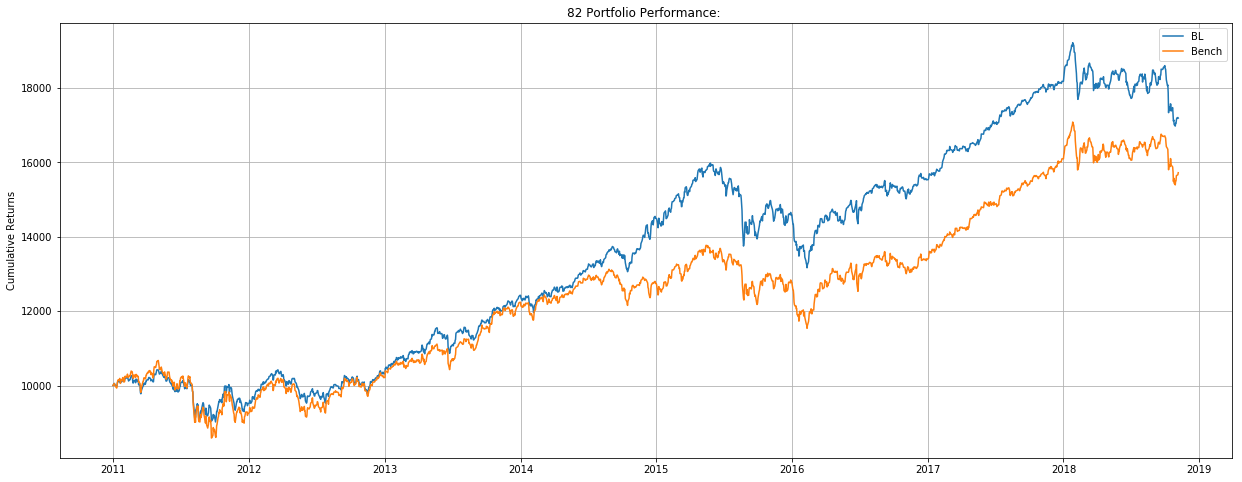

In [225]:
# portfolio cumulative returns
# agg_bl_ret = portfolio_balance
plt.figure(figsize=(21, 8))  # make separate figure
ax = plt.subplot(1, 1, 1)

plt.plot(portfolio_balance, label= 'BL')
# plt.plot(MKZ_portfolio_balance, label= 'MKZ')
# plt.plot(bench_balance0, label= 'MXWD')
plt.plot(bench_balance, label= 'Bench')
# plt.plot(bench_balance1, label= 'LUTLTRUU')
plt.title(filename + ' Portfolio Performance: ')
plt.grid(True,axis='both')
plt.ylabel('Cumulative Returns')
plt.legend(['BL','Bench'])
time_saved = time.strftime("_%Y%m%d_%H%M%S")
# figures_dir = os.path.join(sDir, 'portfolio_log/')
# plt.savefig(figures_dir + filename + 'Portfolio Comparison' + time_saved + '.png')
plt.show()
# pf.timeseries.perf_stats(daily_ret,benchmark_ret)

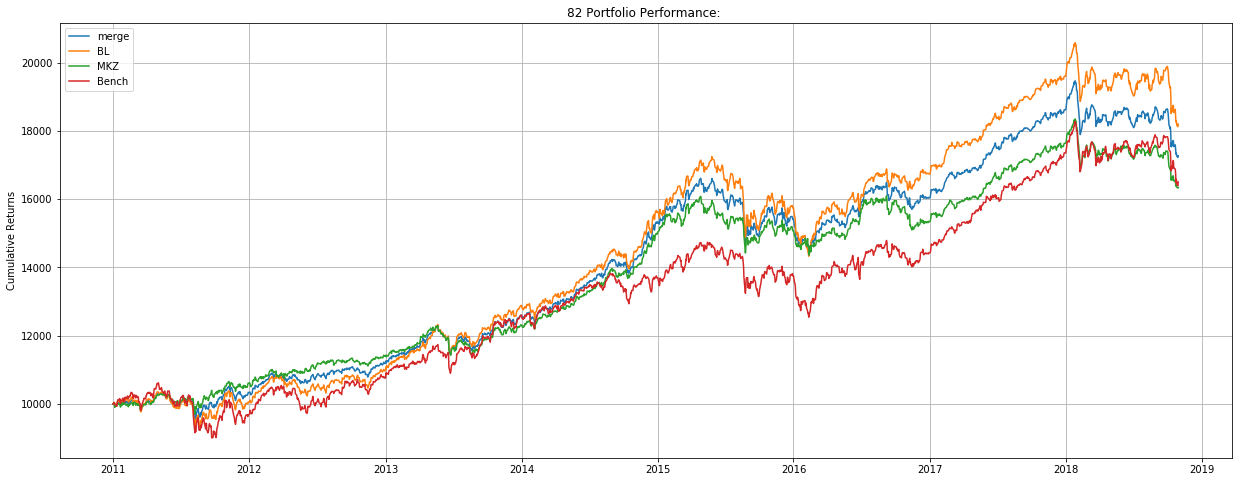

             Balance
2011-01-03  0.004517
2011-01-04 -0.000975
2011-01-05 -0.005853
2011-01-06  0.001710
2011-01-07 -0.000996 
              Balance
2018-10-24 -0.008171
2018-10-25  0.001752
2018-10-26 -0.006718
2018-10-29 -0.002538
2018-10-30  0.004137
            Bench_Balance
2011-01-03       0.004186
2011-01-04      -0.000021
2011-01-05      -0.005657
2011-01-06      -0.000543
2011-01-07      -0.000569 
             Bench_Balance
2018-10-24      -0.015641
2018-10-25       0.005799
2018-10-26      -0.008228
2018-10-29      -0.003016
2018-10-30       0.006865


In [179]:
# portfolio cumulative returns
# agg_bl_ret = portfolio_balance
plt.figure(figsize=(21, 8))  # make separate figure
ax = plt.subplot(1, 1, 1)
plt.plot(merge, label= 'merge')
plt.plot(portfolio_balance, label= 'BL')
plt.plot(MKZ_portfolio_balance, label= 'MKZ')
# plt.plot(bench_balance0, label= 'MXWD')
plt.plot(bench_balance, label= 'Bench')
# plt.plot(bench_balance1, label= 'LUTLTRUU')
plt.title(filename + ' Portfolio Performance: ')
plt.grid(True,axis='both')
plt.ylabel('Cumulative Returns')
plt.legend(['merge','BL','MKZ','Bench'])
time_saved = time.strftime("_%Y%m%d_%H%M%S")
# figures_dir = os.path.join(sDir, 'portfolio_log/')
# plt.savefig(figures_dir + filename + 'Portfolio Comparison' + time_saved + '.png')
plt.show()

In [4]:
# df = portfolio_balance
# merge.index = pd.to_datetime(merge.index)
# df = df.tz_localize('UTC')
# df

Start date,2010-12-31
End date,2018-11-06
Total months,97
,Backtest
Annual return,6.9%
Cumulative returns,71.9%
Annual volatility,8.6%
Sharpe ratio,0.82
Calmar ratio,0.39
Stability,0.94
Max drawdown,-17.6%


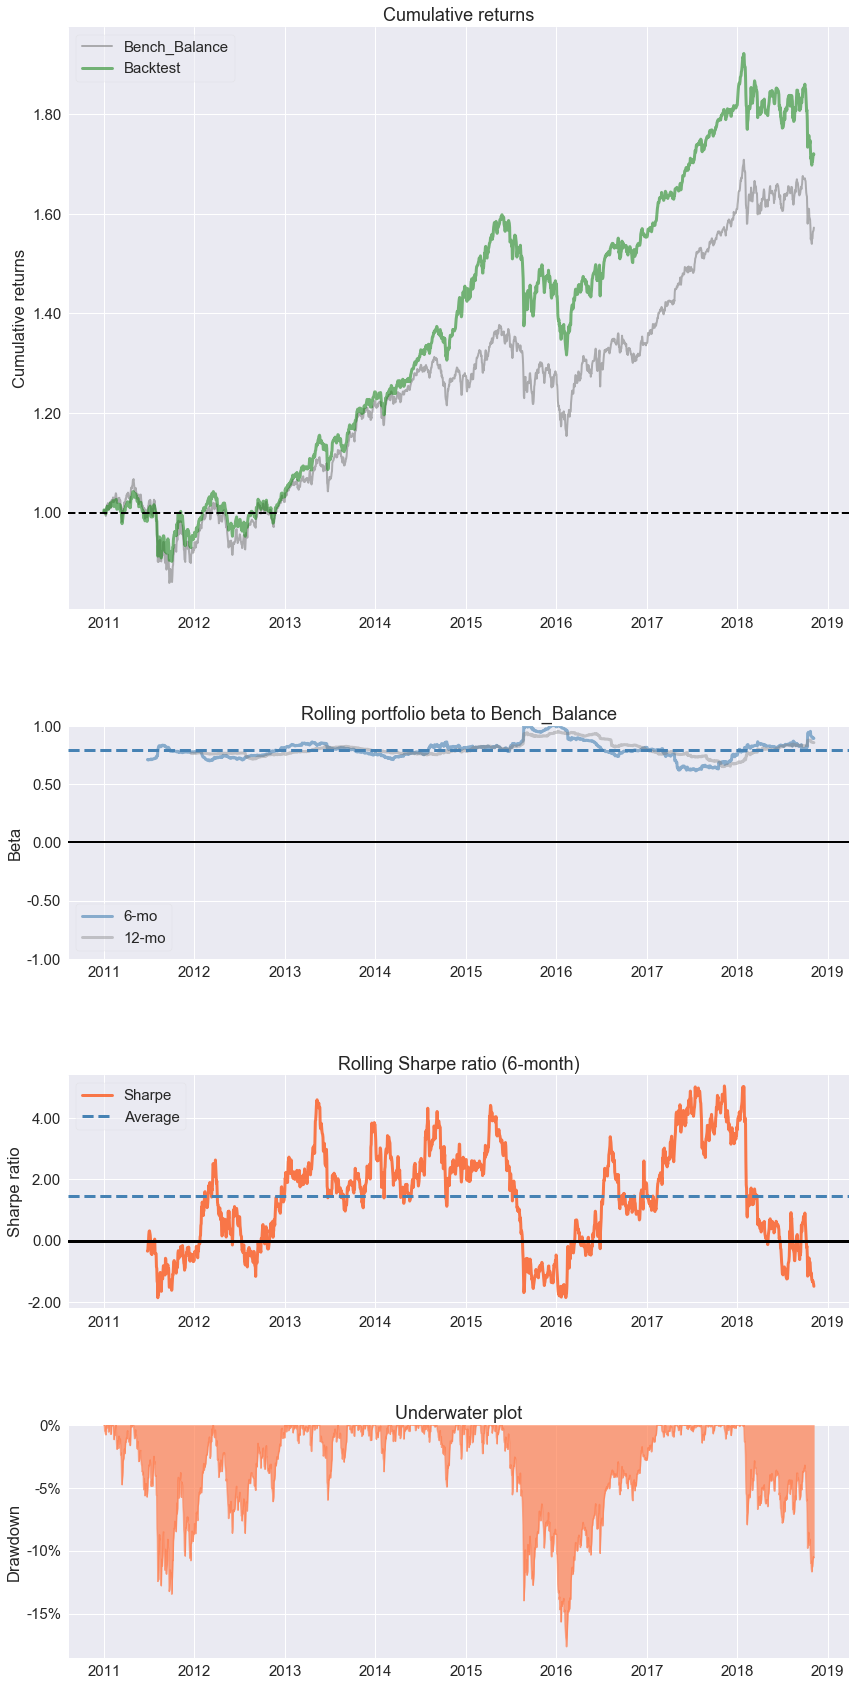

In [226]:
# df.to_csv('balance_report.csv')
df = ln_return(portfolio_balance)
df = df.iloc[:,0]
df2 = ln_return(bench_balance)
df2 = df2.iloc[:,0]
pf.create_simple_tear_sheet(df,benchmark_rets=df2)

Start date,2010-12-31
End date,2018-11-06
Total months,97
,Backtest
Annual return,6.9%
Cumulative returns,71.9%
Annual volatility,8.6%
Sharpe ratio,0.82
Calmar ratio,0.39
Stability,0.94
Max drawdown,-17.6%


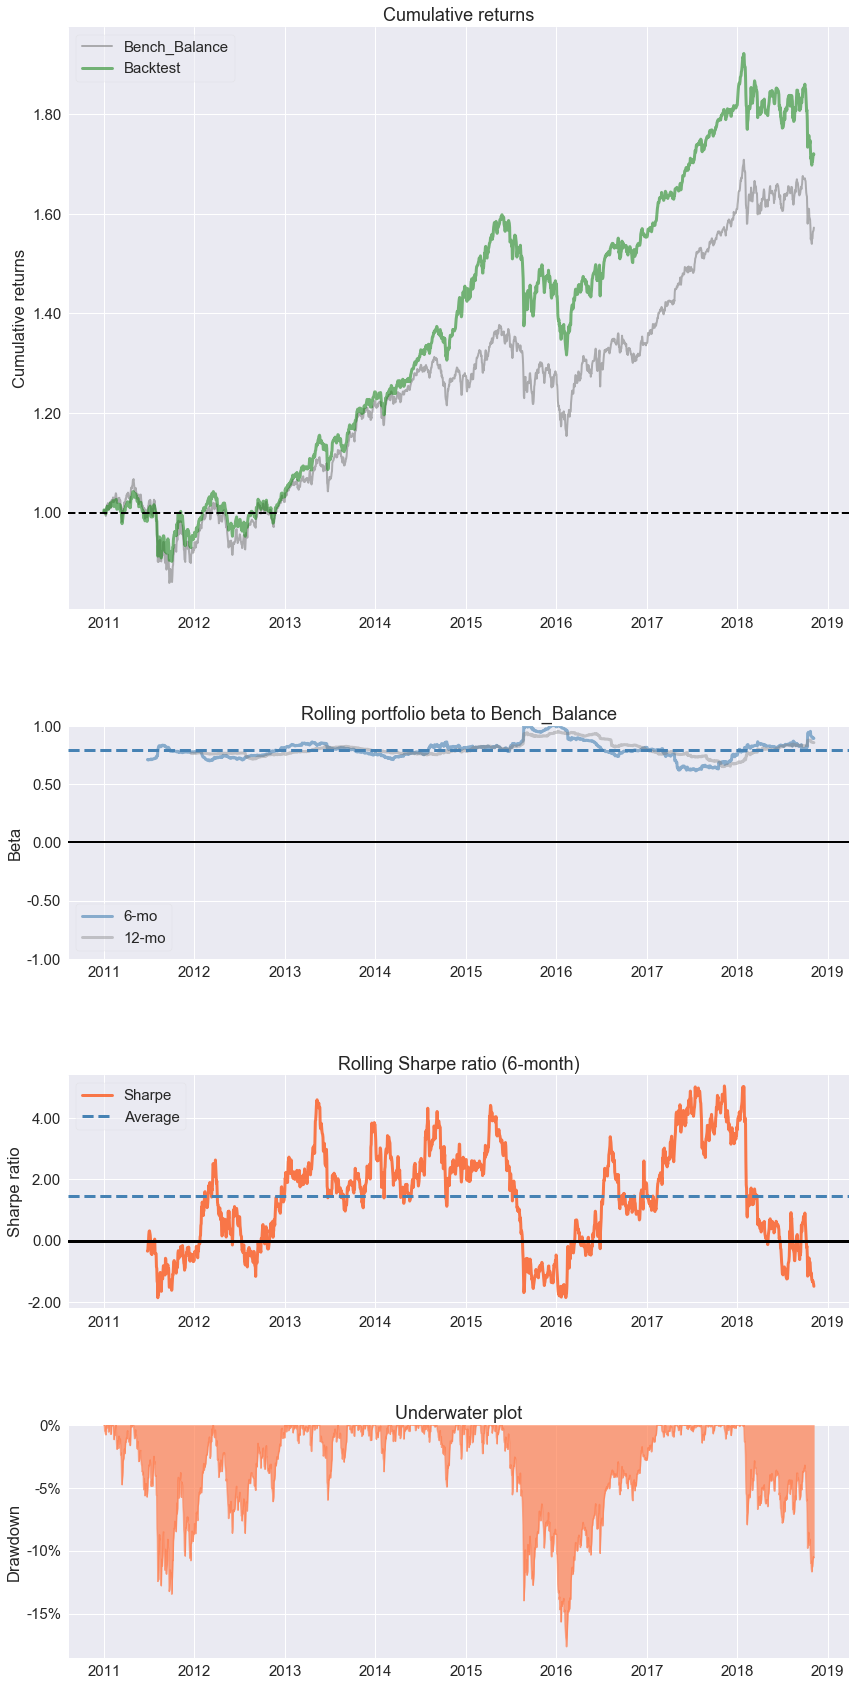

In [215]:
pf.create_simple_tear_sheet(df,benchmark_rets=df2)

In [270]:
pf.timeseries.sharpe_ratio(df)

array([0.97404039])

In [271]:
pf.__file__

'C:\\Anaconda3\\envs\\tensorflow_cpu\\lib\\site-packages\\pyfolio\\__init__.py'